#**Demostração - Aula 5**

Até aqui vimos como usar **word embeddings generativos** (pré-treinados) focando em análise de similaridade e manuseio do espaço vetorial de alguns algoritmos como Word2Vec.

E se tentarmos usar essa "inteligència" para resolver nosso problema de classificação?

###**Análise com skip-gram em Português**

In [ ]:
# Download Word Embeddings Pré-treinadas em Portugûes (skip-gram)
# Repositório original: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

In [1]:
# Download do arquivo no repositório do professor
!wget 'https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip'

# Descompactação do arquivo
!unzip 'skip_s300.zip' # subistitua com nome do arquivo
!ls -la

--2023-12-02 01:06:38--  https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip
Resolving dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)... 3.5.234.115, 52.95.165.7, 52.95.163.63, ...
Connecting to dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)|3.5.234.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/zip]
Saving to: ‘skip_s300.zip’

skip_s300.zip       100%[===================>] 914.21M  29.5MB/s    in 33s     

2023-12-02 01:07:11 (27.7 MB/s) - ‘skip_s300.zip’ saved [958619745/958619745]

Archive:  skip_s300.zip
  inflating: skip_s300.txt           
total 3529584
drwxr-xr-x 1 root root       4096 Dec  2 01:07 .
drwxr-xr-x 1 root root       4096 Dec  2 00:58 ..
drwxr-xr-x 4 root root       4096 Nov 30 14:24 .config
drwxr-xr-x 1 root root       4096 Nov 30 14:27 sample_data
-rw-r--r-- 1 root root 2655642222 Oct  4  2018 skip_s300.txt
-rw-r--r-- 1 root r

In [2]:
# Load do modelo pelo Gensim
from gensim.models import KeyedVectors

model_skip = KeyedVectors.load_word2vec_format('skip_s300.txt')

In [3]:
model_skip

Análise de similaridade

In [4]:
model_skip.similarity('maçã', 'uva')

0.6507031

In [5]:
model_skip.similarity('maçã', 'carro')

0.074699655

In [6]:
pairs = [
    ('carro', 'jipe'),
    ('carro', 'avião'),
    ('carro', 'bicicleta'),
    ('carro', 'cereal'),
    ('carro', 'filosofia'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model_skip.similarity(w1, w2)))

'carro'	'jipe'	0.71
'carro'	'avião'	0.50
'carro'	'bicicleta'	0.55
'carro'	'cereal'	0.08
'carro'	'filosofia'	-0.01


In [7]:
model_skip.most_similar(positive=['carro', 'jipe'], topn=3)

[('furgão', 0.7599552273750305),
 ('caminhão', 0.7516525387763977),
 ('veículo', 0.7478904724121094)]

In [8]:
model_skip.doesnt_match(['fogo', 'água', 'terra', 'mar', 'ar', 'carro'])

'carro'

In [9]:
model_skip.most_similar(positive=['rainha', 'homem'], negative=['mulher'], topn=3)

[('rei', 0.5894271731376648),
 ('monarca', 0.49123090505599976),
 ('guardião', 0.46204233169555664)]

In [10]:
model_skip.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=10)

[('rainha', 0.660095751285553),
 ('consorte', 0.6526049375534058),
 ('esposa', 0.6504772305488586),
 ('sobrinha', 0.6446163654327393),
 ('princesa', 0.6398769617080688),
 ('filha', 0.6342788338661194),
 ('rainha-viúva', 0.6339502334594727),
 ('primogénita', 0.6332842707633972),
 ('princesa-eleitora', 0.6240091323852539),
 ('meia-irmã', 0.6229892373085022)]

In [11]:
palavras = ['um', 'dois', 'três', 'quatro', 'dez', 'onze', 'vinte', 'homem', 'mulher', 'marido', 'esposa', 'casa', 'mesa', 'cadeira']

In [12]:
from sklearn.decomposition import PCA
import numpy as np

sample_vectors = np.array([model_skip[palavra] for palavra in palavras])
pca = PCA(n_components=2)
result = pca.fit_transform(sample_vectors)
result

array([[ 0.17956805,  0.18375202],
       [-1.2229358 , -0.09905089],
       [-1.4864911 , -0.1221025 ],
       [-1.5300087 , -0.05887511],
       [-1.7701347 , -0.13250092],
       [-1.5516897 , -0.14122166],
       [-1.7721732 , -0.26937428],
       [ 0.9042849 , -0.42676726],
       [ 1.5513343 , -0.61161923],
       [ 1.4905175 , -1.1370462 ],
       [ 1.9972197 , -1.73543   ],
       [ 1.0187491 ,  0.33234295],
       [ 0.8883214 ,  1.6803375 ],
       [ 1.303439  ,  2.5375557 ]], dtype=float32)

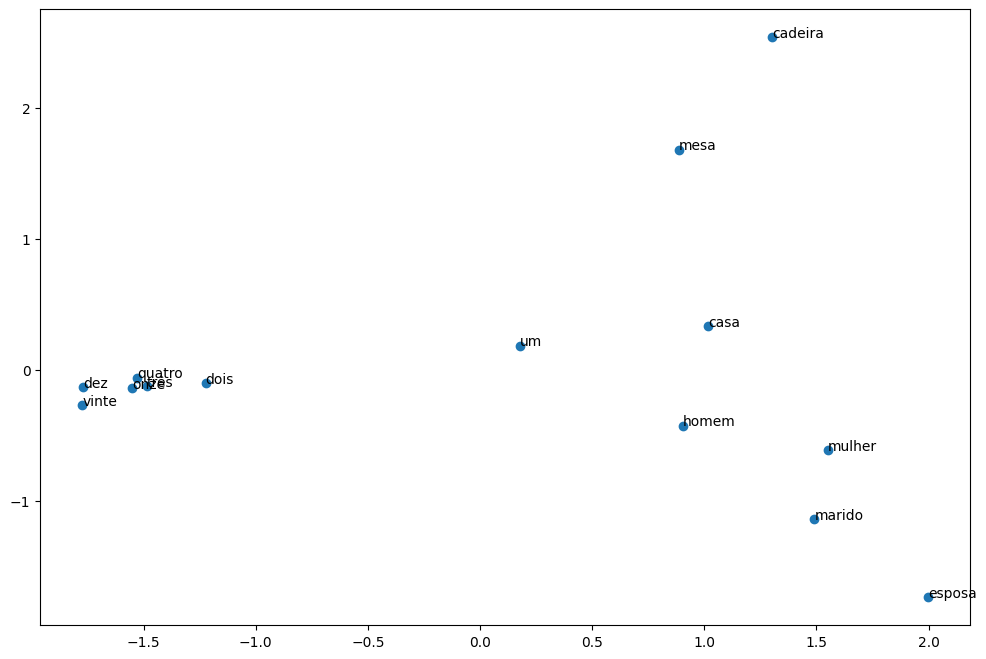

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(palavras):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

### **Classificador com word2vec**

#### Criando um Dataset com base em reviews

In [14]:
# Install Google play scraper: https://github.com/JoMingyu/google-play-scraper
# Google-Play-Scraper provides APIs to easily crawl the Google Play Store for Python without any external dependencies!
!pip install google_play_scraper

In [15]:
import pandas as pd
from tqdm import tqdm
from google_play_scraper import Sort, reviews, app

In [16]:
apps_ids = [
    'br.com.brainweb.ifood',
    'com.cerveceriamodelo.modelonow',
    'com.mcdo.mcdonalds',
    'habibs.alphacode.com.br',
    'com.xiaojukeji.didi.brazil.customer',
    'com.ubercab.eats',
    'com.grability.rappi',
    'burgerking.com.br.appandroid',
    'com.vanuatu.aiqfome'
    ]

In [17]:
SCORE_SAMPLES = 100
SCORE3_FACTOR = 1; TARGET_COLUMN = 'score'

#TARGET_COLUMN = 'sentiment'; SCORE3_FACTOR = 2

In [18]:
app_reviews = []

for app_id in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                app_id,
                lang='pt',
                country='br',
                sort=sort_order,
                count= SCORE3_FACTOR * SCORE_SAMPLES if score == 3 else SCORE_SAMPLES,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = app_id
            app_reviews.extend(rvs)

100%|██████████| 9/9 [00:30<00:00,  3.41s/it]


In [19]:
len(app_reviews)

9000

In [20]:
app_reviews[0]

{'reviewId': '6833203f-c094-44d7-9197-0474dc5d5235',
 'userName': 'Tatiane Coutinho',
 'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjXMf_JXnXuueNiQW3YJlmc3s-edHHzh592_D6xj3nRPzgk3',
 'content': 'O aplicativo é bom referente ao restaurante mas nem sempre é possível acompanhar a entrega em tempo real. Referente ao mercado é péssimo!!! Impossível concluir uma compra nesta modalidade pois enquanto está selecionando os itens o aplicativo trava, fecha e perde-se tudo, principalmente o tempo!!! Para ficar ruim precisa melhorar bastante!!!',
 'score': 1,
 'thumbsUpCount': 415,
 'reviewCreatedVersion': '9.232.1',
 'at': datetime.datetime(2023, 11, 12, 19, 10, 55),
 'replyContent': None,
 'repliedAt': None,
 'appVersion': '9.232.1',
 'sortOrder': 'most_relevant',
 'appId': 'br.com.brainweb.ifood'}

In [21]:
app_reviews_df = pd.DataFrame(app_reviews)

In [22]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,6833203f-c094-44d7-9197-0474dc5d5235,Tatiane Coutinho,https://play-lh.googleusercontent.com/a-/ALV-U...,O aplicativo é bom referente ao restaurante ma...,1,415,9.232.1,2023-11-12 19:10:55,None,NaT,9.232.1,most_relevant,br.com.brainweb.ifood
1,b90f0d99-1dde-421d-9ee0-6e42e00764f2,AUGUSTO CUELLAR,https://play-lh.googleusercontent.com/a-/ALV-U...,"Não consigo fazer compras pelo app no mercado,...",1,34,9.233.0,2023-11-25 15:59:26,None,NaT,9.233.0,most_relevant,br.com.brainweb.ifood
2,b1c0bc2c-862a-4e34-aa89-b8f701be7de1,Juliana Reis,https://play-lh.googleusercontent.com/a-/ALV-U...,"Uso faz tempo, mas foi a primeira vez que acon...",1,21,9.233.0,2023-11-25 18:04:20,None,NaT,9.233.0,most_relevant,br.com.brainweb.ifood
3,346d065a-1e21-469f-8e39-a3486cc76753,Lu Gama,https://play-lh.googleusercontent.com/a/ACg8oc...,Fazer compras de mercado está horrível. Se o p...,1,29,9.232.1,2023-11-23 12:01:29,None,NaT,9.232.1,most_relevant,br.com.brainweb.ifood
4,108736e6-4d49-4478-a390-fd28fbf140cc,Katthy Fioramonte,https://play-lh.googleusercontent.com/a-/ALV-U...,"O app é bom, mas tem bugs referentes a cupons ...",1,30,9.232.1,2023-11-17 17:32:40,None,NaT,9.232.1,most_relevant,br.com.brainweb.ifood


In [23]:
app_reviews_df['sentiment'] = 0
app_reviews_df.loc[app_reviews_df["score"] < 3, "sentiment"] = -1
app_reviews_df.loc[app_reviews_df["score"] > 3, "sentiment"] = 1

In [24]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,sentiment
0,6833203f-c094-44d7-9197-0474dc5d5235,Tatiane Coutinho,https://play-lh.googleusercontent.com/a-/ALV-U...,O aplicativo é bom referente ao restaurante ma...,1,415,9.232.1,2023-11-12 19:10:55,None,NaT,9.232.1,most_relevant,br.com.brainweb.ifood,-1
1,b90f0d99-1dde-421d-9ee0-6e42e00764f2,AUGUSTO CUELLAR,https://play-lh.googleusercontent.com/a-/ALV-U...,"Não consigo fazer compras pelo app no mercado,...",1,34,9.233.0,2023-11-25 15:59:26,None,NaT,9.233.0,most_relevant,br.com.brainweb.ifood,-1
2,b1c0bc2c-862a-4e34-aa89-b8f701be7de1,Juliana Reis,https://play-lh.googleusercontent.com/a-/ALV-U...,"Uso faz tempo, mas foi a primeira vez que acon...",1,21,9.233.0,2023-11-25 18:04:20,None,NaT,9.233.0,most_relevant,br.com.brainweb.ifood,-1
3,346d065a-1e21-469f-8e39-a3486cc76753,Lu Gama,https://play-lh.googleusercontent.com/a/ACg8oc...,Fazer compras de mercado está horrível. Se o p...,1,29,9.232.1,2023-11-23 12:01:29,None,NaT,9.232.1,most_relevant,br.com.brainweb.ifood,-1
4,108736e6-4d49-4478-a390-fd28fbf140cc,Katthy Fioramonte,https://play-lh.googleusercontent.com/a-/ALV-U...,"O app é bom, mas tem bugs referentes a cupons ...",1,30,9.232.1,2023-11-17 17:32:40,None,NaT,9.232.1,most_relevant,br.com.brainweb.ifood,-1


In [25]:
app_reviews_df['sentiment'].value_counts()

-1    3600
 1    3600
 0    1800
Name: sentiment, dtype: int64

In [26]:
df_model = app_reviews_df[['content','score','sentiment']]

In [27]:
# Normalização de texto
import string

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# lista de stopwords do NLTK
stopwords = nltk.corpus.stopwords.words('portuguese')

# função que remove pontuação
def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text

# função que normaliza o texto e remove stopwords
def norm_tokenize(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = "".join([w for w in text if not w.isdigit()])
    text = word_tokenize(text)
    text = [x for x in text if x not in stopwords]
    text = [y for y in text if len(y) > 2]
    #text " ".join([t for t in text])
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
df_model['tokens'] = df_model['content'].apply(norm_tokenize)

<ipython-input-28-a8bb658abe50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['tokens'] = df_model['content'].apply(norm_tokenize)


In [29]:
df_model.head()

,content,score,sentiment,tokens
0,O aplicativo é bom referente ao restaurante ma...,1,-1,"[aplicativo, bom, referente, restaurante, semp..."
1,"Não consigo fazer compras pelo app no mercado,...",1,-1,"[consigo, fazer, compras, app, mercado, fica, ..."
2,"Uso faz tempo, mas foi a primeira vez que acon...",1,-1,"[uso, faz, tempo, primeira, vez, aconteceu, fa..."
3,Fazer compras de mercado está horrível. Se o p...,1,-1,"[fazer, compras, mercado, horrível, preço, alt..."
4,"O app é bom, mas tem bugs referentes a cupons ...",1,-1,"[app, bom, bugs, referentes, cupons, pagamento..."


In [30]:
# Exemplo 1: Função para obter embeddings médios para cada texto
vectorizer = model_skip

def average_vector(tokens):
    vector_size = vectorizer.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for word in tokens:
        if word in vectorizer:
            ctr += 1
            wv_res += vectorizer[word]
    wv_res = wv_res/ctr
    return wv_res

#vectorizer['maquiagem']

In [122]:
# Exemplo 2: Função para obter embeddings médios para cada texto
'''
vectorizer = model_skip

def average_vector(words):
  vectors = [vectorizer[word] for word in words if word in vectorizer]
  if vectors:
    return sum(vectors) / len(vectors)
  else:
    vector_size = vectorizer.vector_size
    wv_res = np.zeros(vector_size)
    return wv_res
'''

In [31]:
# Tokenizar e obter embeddings médios para cada texto
df_model['vector'] = df_model['tokens'].apply(average_vector)

<ipython-input-31-e1e7b11c2590>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['vector'] = df_model['tokens'].apply(average_vector)


In [124]:
#df_model['vector'][0]

In [32]:
df_model.head()

,content,score,sentiment,tokens,vector
0,O aplicativo é bom referente ao restaurante ma...,1,-1,"[aplicativo, bom, referente, restaurante, semp...","[0.022093943247039404, -0.10116042851337365, -..."
1,"Não consigo fazer compras pelo app no mercado,...",1,-1,"[consigo, fazer, compras, app, mercado, fica, ...","[0.022551725269295275, -0.03744947558734566, -..."
2,"Uso faz tempo, mas foi a primeira vez que acon...",1,-1,"[uso, faz, tempo, primeira, vez, aconteceu, fa...","[-0.03237802375021369, -0.03730888357710873, -..."
3,Fazer compras de mercado está horrível. Se o p...,1,-1,"[fazer, compras, mercado, horrível, preço, alt...","[-0.00489854026032058, -0.11659345957702277, -..."
4,"O app é bom, mas tem bugs referentes a cupons ...",1,-1,"[app, bom, bugs, referentes, cupons, pagamento...","[0.021216288316421784, -0.07433240338174912, -..."


In [33]:
x = df_model['vector'].to_list()
y = df_model[TARGET_COLUMN].to_list()

In [44]:
len(x[0])

300

In [34]:
from sklearn.model_selection import train_test_split
# divisão da amostra entre treino e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state = 42)

#### Treina modelo

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# treinamento do modelo ávore de decisão com o dataframe de treino
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = model.predict(x_test)

In [36]:
# Avaliação do modelo

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.62      0.56       540
           2       0.41      0.43      0.42       540
           3       0.44      0.34      0.38       540
           4       0.46      0.40      0.43       540
           5       0.58      0.63      0.61       540

    accuracy                           0.48      2700
   macro avg       0.48      0.48      0.48      2700
weighted avg       0.48      0.48      0.48      2700

0.48333333333333334


#### Comprando o resultado com vetorização Bag of Words

In [37]:
def token_to_text(tokens):
    return " ".join(tokens)

df_model['norm_content'] = df_model['tokens'].apply(token_to_text)

<ipython-input-37-12ec7bc66d6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['norm_content'] = df_model['tokens'].apply(token_to_text)


In [38]:
df_model.head()

,content,score,sentiment,tokens,vector,norm_content
0,O aplicativo é bom referente ao restaurante ma...,1,-1,"[aplicativo, bom, referente, restaurante, semp...","[0.022093943247039404, -0.10116042851337365, -...",aplicativo bom referente restaurante sempre po...
1,"Não consigo fazer compras pelo app no mercado,...",1,-1,"[consigo, fazer, compras, app, mercado, fica, ...","[0.022551725269295275, -0.03744947558734566, -...",consigo fazer compras app mercado fica aparece...
2,"Uso faz tempo, mas foi a primeira vez que acon...",1,-1,"[uso, faz, tempo, primeira, vez, aconteceu, fa...","[-0.03237802375021369, -0.03730888357710873, -...",uso faz tempo primeira vez aconteceu fazer ped...
3,Fazer compras de mercado está horrível. Se o p...,1,-1,"[fazer, compras, mercado, horrível, preço, alt...","[-0.00489854026032058, -0.11659345957702277, -...",fazer compras mercado horrível preço alterar d...
4,"O app é bom, mas tem bugs referentes a cupons ...",1,-1,"[app, bom, bugs, referentes, cupons, pagamento...","[0.021216288316421784, -0.07433240338174912, -...",app bom bugs referentes cupons pagamentos via ...


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df_train, df_test = train_test_split(
      df_model,
      test_size = 0.3,
      random_state = 42
  )

vect = CountVectorizer()
vect.fit(df_train.norm_content)
x_train = vect.transform(df_train.norm_content)
x_test = vect.transform(df_test.norm_content)
y_train = df_train[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

# treinamento do modelo ávore de decisão com o dataframe de treino
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = model.predict(x_test)

In [40]:
# Avaliação do modelo

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.65      0.62       558
           2       0.47      0.43      0.45       535
           3       0.47      0.40      0.43       526
           4       0.50      0.53      0.51       559
           5       0.60      0.65      0.62       522

    accuracy                           0.53      2700
   macro avg       0.53      0.53      0.53      2700
weighted avg       0.53      0.53      0.53      2700

0.5311111111111111


In [42]:
x_train.shape

(6300, 9456)

### **Classificador com Transformers**

#### Sentence transformers

O Sentence-Transformers é uma biblioteca construída sobre o framework Transformers, e foi projetada para a geração de representações semânticas de sentenças (documentos ou pedaços de texto) de alta qualidade.

Vamos utilizar o modelo 'distiluse-base-multilingual-cased-v2', que é um modelo da família DistilBERT (uma versão mais leve e eficiente do BERT) que foi pré-treinado especificamente para a geração de embeddings de sentenças multilíngues.

In [43]:
!pip install sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.3 MB/s eta 0:00:00


In [44]:
from sentence_transformers import SentenceTransformer

st = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
review_embeddings = st.encode(df_model['content'])

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [45]:
len(review_embeddings[0])

512

In [47]:
x = review_embeddings
y = df_model[TARGET_COLUMN].to_list()

In [49]:
from sklearn.model_selection import train_test_split
# divisão da amostra entre treino e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state = 42)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# treinamento do modelo ávore de decisão com o dataframe de treino
log_reg = RandomForestClassifier(random_state=42)
log_reg.fit(x_train, y_train)

# escoragem da classificação na amostra de teste
y_pred = log_reg.predict(x_test)

In [51]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.69      0.60       540
           2       0.48      0.45      0.46       540
           3       0.47      0.41      0.44       540
           4       0.51      0.47      0.49       540
           5       0.67      0.66      0.66       540

    accuracy                           0.53      2700
   macro avg       0.53      0.53      0.53      2700
weighted avg       0.53      0.53      0.53      2700

0.534074074074074


## ***Exercício***

Você deverá treinar o modelo de classificação do dataset de produtos [1] utilizando as duas abordagens apresentadas aqui (embeddings word2vec (CBOW ou skip-gram) e sentence transformer) e comparar os resultados.

*   Remover registros com valores nulos;
*   Contatenar as colunas de nome e descrição;
*   Aplicar normalização da demo;
*   Amostra de 30% para teste e random_state = 42.


[1] https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv

In [ ]:
# resposta'

#***O que você achou da aula de hoje?***

Pelo aplicativo da FIAP ou pelo site

(Entrar no FIAP, e no menu clicar em Experience Survey)

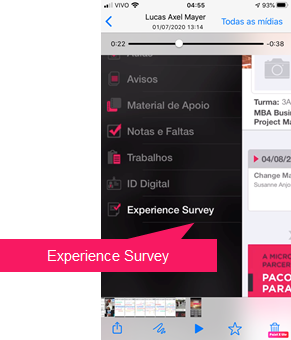